In [1]:
import os, sys, re, datetime, random, gzip, json
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from itertools import accumulate
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

from time import time
from math import ceil
from multiprocessing import Pool
from sentence_transformers import SentenceTransformer, models, losses, InputExample

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

PROJ_PATH = Path(os.path.join(re.sub("/BERT_ABSA.*$", '', os.getcwd()), 'BERT_ABSA'))
print(f'PROJ_PATH={PROJ_PATH}')
sys.path.insert(1, str(PROJ_PATH))
sys.path.insert(1, str(PROJ_PATH/'src'))
import utils
import matplotlib.pyplot as plt

%matplotlib inline

/tmp/ipykernel_2714419/2032842600.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


PROJ_PATH=/home/hoang/github/BERT_ABSA


In [2]:
# glob.glob('../model/restaurants/*.ckpt')

In [3]:
import nltk
def tokenization(text):
    text = text.strip().lower()
    tokens = nltk.word_tokenize(text)
    return tokens

def bucketize(text_length):
    if text_length < 15:
        return 0
    elif text_length < 20:
        return 1
    elif text_length < 30:
        return 2
    else:
        return 3
def get_pred_label(x):
    if max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_0:
        return 'positive'
    elif max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_1:
        return 'negative'
    else: return 'neutral'

In [4]:
df = pd.read_csv('../output/bert_laptop.csv')
labelid2str = {0: 'positive', 1: 'negative', 2: 'neutral'}
labelid2str_ordinal = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label_id_ordinal'] = df['label'].map({j:i for i,j in labelid2str_ordinal.items()})
df['pred_label'] = df[['pred_0', 'pred_1', 'pred_2']].apply(get_pred_label, axis=1)
df['pred_id'] = df['pred_label'].map({j:i for i,j in labelid2str.items()})
df['pred_id_ordinal'] = df['pred_label'].map({j:i for i,j in labelid2str_ordinal.items()})
df['tokens'] = df['text'].apply(tokenization)
df['text_length'] = df['tokens'].apply(lambda x: len(x))
df['length_group'] = df['text_length'].apply(bucketize)

In [5]:
df.head()

,id,text,term,label_id,label,tvt,pred_0,pred_1,pred_2,label_id_ordinal,pred_label,pred_id,pred_id_ordinal,tokens,text_length,length_group
0,2970,I did not have to call the support line at all.,support line,2,neutral,train,0.008853,0.946791,0.044356,1,negative,1,0,"[i, did, not, have, to, call, the, support, li...",12,0
1,2338,I take it everywhere with me because it's so e...,carry,0,positive,train,0.997106,0.001536,0.001358,2,positive,0,2,"[i, take, it, everywhere, with, me, because, i...",14,0
2,2674,One drawback I noticed was sound quality via USB.,sound quality via USB,1,negative,train,0.010381,0.984811,0.004808,0,negative,1,0,"[one, drawback, i, noticed, was, sound, qualit...",10,0
3,3011,"Great OS, fabulous improvements to the existin...",OS,0,positive,train,0.990099,0.007549,0.002352,2,positive,0,2,"[great, os, ,, fabulous, improvements, to, the...",20,2
4,76,"I even got my teenage son one, because of the ...",Photobooth,0,positive,train,0.990355,0.004753,0.004892,2,positive,0,2,"[i, even, got, my, teenage, son, one, ,, becau...",27,2


In [6]:
p = range(0, 101, 10)
print(list(zip(p, np.percentile(df['text_length'], p))))

[(0, 3.0), (10, 9.0), (20, 12.0), (30, 14.0), (40, 16.0), (50, 19.0), (60, 21.0), (70, 24.0), (80, 29.0), (90, 37.0), (100, 83.0)]


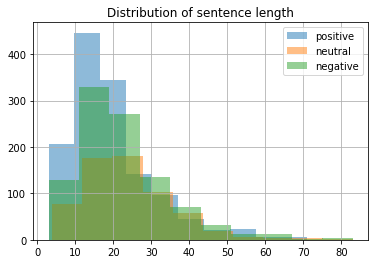

In [7]:
i1 = df['label']=='positive'
i2 = df['label']=='neutral'
i3 = df['label']=='negative'
col = 'text_length'
df[i1][col].hist(alpha=0.5, label='positive')
df[i2][col].hist(alpha=0.5, label='neutral')
df[i3][col].hist(alpha=0.5, label='negative')
plt.legend()
plt.title('Distribution of sentence length')
plt.show()

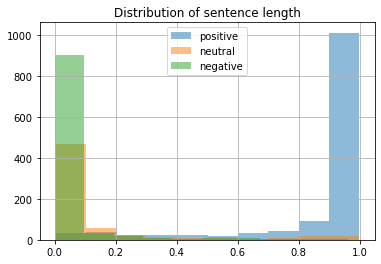

In [8]:
i1 = df['label']=='positive'
i2 = df['label']=='neutral'
i3 = df['label']=='negative'
col = 'pred_0'
df[i1][col].hist(alpha=0.5, label='positive')
df[i2][col].hist(alpha=0.5, label='neutral')
df[i3][col].hist(alpha=0.5, label='negative')
plt.legend()
plt.title('Distribution of sentence length')
plt.show()

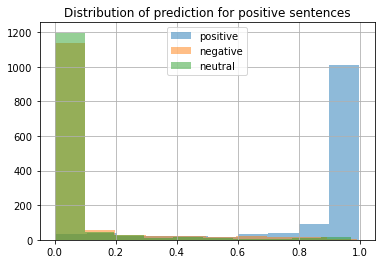

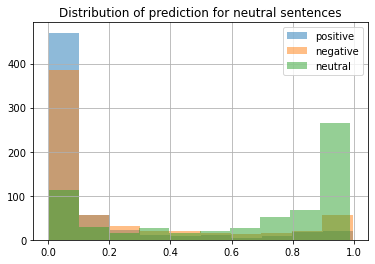

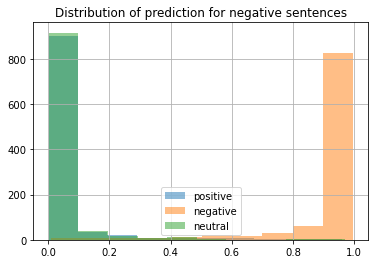

In [9]:
i1 = df['label']=='positive'
i2 = df['label']=='neutral'
i3 = df['label']=='negative'
col1 = 'pred_0'
col2 = 'pred_1'
col3 = 'pred_2'
df[i1][col1].hist(alpha=0.5, label='positive')
df[i1][col2].hist(alpha=0.5, label='negative')
df[i1][col3].hist(alpha=0.5, label='neutral')
plt.legend()
plt.title('Distribution of prediction for positive sentences')
plt.show()

i1 = df['label']=='positive'
i2 = df['label']=='neutral'
i3 = df['label']=='negative'
col1 = 'pred_0'
col2 = 'pred_1'
col3 = 'pred_2'
df[i2][col1].hist(alpha=0.5, label='positive')
df[i2][col2].hist(alpha=0.5, label='negative')
df[i2][col3].hist(alpha=0.5, label='neutral')
plt.legend()
plt.title('Distribution of prediction for neutral sentences')
plt.show()


i1 = df['label']=='positive'
i2 = df['label']=='neutral'
i3 = df['label']=='negative'
col1 = 'pred_0'
col2 = 'pred_1'
col3 = 'pred_2'
df[i3][col1].hist(alpha=0.5, label='positive')
df[i3][col2].hist(alpha=0.5, label='negative')
df[i3][col3].hist(alpha=0.5, label='neutral')
plt.legend()
plt.title('Distribution of prediction for negative sentences')
plt.show()

In [10]:
pred_results = df.groupby(['label', 'pred_label'], as_index=False).size().sort_values('size', ascending=False)
pred_results.pivot_table(index='label', columns='pred_label', values='size', aggfunc='sum')

pred_label,negative,neutral,positive
label,,,
negative,958,14,26
neutral,125,439,69
positive,83,47,1205


In [11]:
df['label'].value_counts()

positive    1335
negative     998
neutral      633
Name: label, dtype: int64

In [12]:
df['tvt'].value_counts()

train    1862
test      638
val       466
Name: tvt, dtype: int64

In [13]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from scipy.stats import pearsonr

In [14]:
def get_tvt_idx(df, tvt_col='tvt'):
    '''
    Get train/val/test indexes
    
    Returns
    -------
        [('train', train_idx), ('val', val_idx), ('test', test_idx)]
        
    '''
    tvt_idx = [
        ('train', df['tvt']=='train'),
        ('val', df['tvt']=='val'),
        ('test', df['tvt']=='test'),
    ]
    return tvt_idx  

def get_feature_importance_from_model(fmodel, sort=True):
    model = fmodel['model']
    feature_cnames = fmodel['cname_feats']
    pd_imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='gain').items()), columns=['feature', 'importance'])
    pd_imp['feature'] = pd_imp['feature'].replace({'f{}'.format(str(i)): feature_cnames[i] for i in range(len(feature_cnames))}) # for ranker
    if sort:
        pd_imp = pd_imp.sort_values('importance', ascending=False)
    return pd_imp

def compute_evaluation_metrics(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test):
    train_score = model.predict_proba(x_train, ntree_limit=best_ntree)
    train_pred = model.predict(x_train, ntree_limit=best_ntree)
    val_score = model.predict_proba(x_val, ntree_limit=best_ntree)
    val_pred = model.predict(x_val, ntree_limit=best_ntree)
    test_score = model.predict_proba(x_test, ntree_limit=best_ntree)
    test_pred = model.predict(x_test, ntree_limit=best_ntree)
    
    train_auc = roc_auc_score(y_true=y_train, y_score=train_score, multi_class='ovo')
    train_acc = accuracy_score(y_true=y_train, y_pred=train_pred)
    val_auc = roc_auc_score(y_true=y_val, y_score=val_score, multi_class='ovo')
    val_acc = accuracy_score(y_true=y_val, y_pred=val_pred)
    test_auc = roc_auc_score(y_true=y_test, y_score=test_score, multi_class='ovo')
    test_acc = accuracy_score(y_true=y_test, y_pred=test_pred)
    return train_auc, train_acc, val_auc, val_acc, test_auc, test_acc

def train_xgb(dfXY, tvt_idx, cname_feats, cname_target='label', option_init={}, option_fit={}):
    default_option_fit = {
        'eval_metric': 'auc',
        'verbose': False,
        'early_stopping_rounds': 20,
    }
    default_option_init = {
        'objective': 'binary:logistic',
#         'max_depth': 5,
#         'n_estimators': 200,   
#         'learning_rate': 0.001,
#         'gamma': 0.0,
#         'min_child_weight': 10,
#         'subsample': 0.1,
#         'tree_method': 'hist',
#         'colsample_bytree': 0.5,
#         'colsample_bylevel': 0.5,
#         'reg_alpha': 0.0,
#         'reg_lambda': 1.0,
        'random_state': 0,
        'n_jobs': 32
    }
    default_option_fit.update(option_fit)
    default_option_init.update(option_init)
    option_fit = default_option_fit
    option_init = default_option_init
    
    # train/test
    x_train = dfXY[tvt_idx[0][1]][cname_feats].values
    y_train = dfXY[tvt_idx[0][1]][cname_target].values.astype("i4")
    x_val = dfXY[tvt_idx[1][1]][cname_feats].values
    y_val = dfXY[tvt_idx[1][1]][cname_target].values.astype("i4")
    x_test = dfXY[tvt_idx[2][1]][cname_feats].values
    y_test = dfXY[tvt_idx[2][1]][cname_target].values.astype("i4")
    
    # classify
    eval_set = [
        (x_train, y_train),
        (x_val, y_val),
    ]
    
    model = xgb.XGBClassifier(**option_init)
    model.fit(x_train, y_train, eval_set=eval_set, **option_fit)
    best_ntree = model.get_booster().best_ntree_limit  
    
    train_auc, train_acc, val_auc, val_acc, test_auc, test_acc = compute_evaluation_metrics(
        model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test)
    print('n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc')
    print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
        len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
        train_auc, train_acc, val_auc, val_acc, test_auc, test_acc))
    
    # track
    fmodel = {
        'model': model,
        'cname_target': cname_target,
        'cname_feats': cname_feats,  
    }
    return fmodel

def compute_evaluation_metrics_reg(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test):
    pred_train = model.predict(x_train, ntree_limit=best_ntree)
    pred_val = model.predict(x_val, ntree_limit=best_ntree)
    pred_test = model.predict(x_test, ntree_limit=best_ntree)
    
    mse_train = mean_squared_error(y_true=y_train, y_pred=pred_train)
    corr_train = pearsonr(y_train, pred_train)[0]
    mse_val = mean_squared_error(y_true=y_val, y_pred=pred_val)
    corr_val = pearsonr(y_val, pred_val)[0]
    mse_test = mean_squared_error(y_true=y_test, y_pred=pred_test)
    corr_test = pearsonr(y_test, pred_test)[0]
    return mse_train, corr_train, mse_val, corr_val, mse_test, corr_test

def train_xgb_regressor(dfXY, tvt_idx, cname_feats, cname_target='label', option_init={}, option_fit={}):
    default_option_fit = {
        'eval_metric': 'rmse',
        'verbose': False,
        'early_stopping_rounds': 20,
    }
    default_option_init = {
        'objective': 'reg:squarederror',
#         'max_depth': 5,
#         'n_estimators': 200,   
#         'learning_rate': 0.001,
#         'gamma': 0.0,
#         'min_child_weight': 10,
#         'subsample': 0.1,
#         'tree_method': 'hist',
#         'colsample_bytree': 0.5,
#         'colsample_bylevel': 0.5,
#         'reg_alpha': 0.0,
#         'reg_lambda': 1.0,
        'random_state': 0,
        'n_jobs': 32
    }
    default_option_fit.update(option_fit)
    default_option_init.update(option_init)
    option_fit = default_option_fit
    option_init = default_option_init
    
    # train/test
    x_train = dfXY[tvt_idx[0][1]][cname_feats].values
    y_train = dfXY[tvt_idx[0][1]][cname_target].values.astype("i4")
    x_val = dfXY[tvt_idx[1][1]][cname_feats].values
    y_val = dfXY[tvt_idx[1][1]][cname_target].values.astype("i4")
    x_test = dfXY[tvt_idx[2][1]][cname_feats].values
    y_test = dfXY[tvt_idx[2][1]][cname_target].values.astype("i4")
    
    # classify
    eval_set = [
        (x_train, y_train),
        (x_val, y_val),
    ]
    
    model = xgb.XGBRegressor(**option_init)
    model.fit(x_train, y_train, eval_set=eval_set, **option_fit)
    best_ntree = model.get_booster().best_ntree_limit  
    
    mse_train, corr_train, mse_val, corr_val, mse_test, corr_test = compute_evaluation_metrics_reg(
        model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test)
    print('n_features n_train n_val n_test n_tree mse_train corr_train mse_val corr_val mse_test corr_test')
    print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
        len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
        mse_train, corr_train, mse_val, corr_val, mse_test, corr_test))
   
    # track
    fmodel = {
        'model': model,
        'cname_target': cname_target,
        'cname_feats': cname_feats,  
    }
    return fmodel

In [15]:
i_test = df['tvt']=='test'
test_auc = roc_auc_score(
    y_true=df[i_test]['label_id'], y_score=df[i_test][['pred_0', 'pred_1', 'pred_2']], multi_class='ovo')
test_acc = accuracy_score(y_true=df[i_test]['label_id'], y_pred=df[i_test]['pred_id'])
print(f'Test AUC: {test_auc}')
print(f'Test ACC: {test_acc}')

Test AUC: 0.865054829888887
Test ACC: 0.7163009404388715


In [26]:
i_test = df['tvt']=='test'
test_auc = roc_auc_score(
    y_true=df[i_test]['label_id_ordinal'], y_score=df[i_test][['pred_1', 'pred_2', 'pred_0']], multi_class='ovo')
test_acc = accuracy_score(y_true=df[i_test]['label_id_ordinal'], y_pred=df[i_test]['pred_id_ordinal'])
test_corr = pearsonr(df[i_test]['label_id_ordinal'], df[i_test]['pred_id_ordinal'])[0]
print(f'Test AUC: {test_auc}')
print(f'Test ACC: {test_acc}')
print(f'Test CORR: {test_corr}')

Test AUC: 0.865054829888887
Test ACC: 0.7163009404388715
Test CORR: 0.6674615965403976


In [22]:
tvt_idx = get_tvt_idx(df)
cname_feats = sorted(['pred_0', 'pred_1', 'pred_2', 'length_group'])
option_init = {
    'n_estimators': 1000,
    'learning_rate': 0.001,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'random_state': 3,
}
fmodel = train_xgb(
    dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
display(get_feature_importance_from_model(fmodel))

n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc
4 1862 466 638 24 0.97998 0.94092 0.97447 0.92275 0.84545 0.73197


/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,feature,importance
2,pred_1,41.086807
1,pred_0,35.766983
3,pred_2,27.513412
0,length_group,2.499413


In [23]:
tvt_idx = get_tvt_idx(df)
cname_feats = sorted(['pred_0', 'pred_1', 'pred_2', 'length_group'])
option_init = {
    'n_estimators': 20000,
    'learning_rate': 0.001,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'random_state': 0,
}
fmodel = train_xgb_regressor(
    dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id_ordinal', option_init=option_init)
display(get_feature_importance_from_model(fmodel))

n_features n_train n_val n_test n_tree mse_train corr_train mse_val corr_val mse_test corr_test
4 1862 466 638 4295 0.05879 0.96425 0.10211 0.93716 0.32468 0.72815


/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,feature,importance
2,pred_1,9.571001
1,pred_0,9.051040
3,pred_2,2.561548
0,length_group,0.389143


In [120]:
# def get_XYG(pdXY, features, target, query_id):
#     z = pdXY.sort_values(query_id)
#     X = z[features].values
#     Y = z[target].values
#     G = list(pdXY.groupby(query_id).size())
#     return X,Y,G

# def compute_evaluation_metrics(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test):
# #     train_score = model.predict_proba(x_train, ntree_limit=best_ntree)
#     train_pred = model.predict(x_train, ntree_limit=best_ntree)
# #     val_score = model.predict_proba(x_val, ntree_limit=best_ntree)
#     val_pred = model.predict(x_val, ntree_limit=best_ntree)
# #     test_score = model.predict_proba(x_test, ntree_limit=best_ntree)
#     test_pred = model.predict(x_test, ntree_limit=best_ntree)
#     print(train_pred)
#     train_auc = roc_auc_score(y_true=y_train, y_score=train_pred)
#     train_acc = 0
#     val_auc = roc_auc_score(y_true=y_val, y_score=train_pred, multi_class='ovo')
#     val_acc = 0
#     test_auc = roc_auc_score(y_true=y_test, y_score=train_pred, multi_class='ovo')
#     test_acc = 0
#     return train_auc, train_acc, val_auc, val_acc, test_auc, test_acc

# def train_xgb_ranker(
#     dfXY, tvt_idx, cname_feats, cname_target='label', query_id='length_group', option_init={}, option_fit={}):
#     default_option_fit = {
#         'eval_metric': 'auc',
#         'verbose': False,
#         'early_stopping_rounds': 20,
#     }
#     default_option_init = {
#            'objective': 'rank:pairwise',
# #         'max_depth': 5,
# #         'n_estimators': 200,   
# #         'learning_rate': 0.001,
# #         'gamma': 0.0,
# #         'min_child_weight': 10,
# #         'subsample': 0.1,
# #         'tree_method': 'hist',
# #         'colsample_bytree': 0.5,
# #         'colsample_bylevel': 0.5,
# #         'reg_alpha': 0.0,
# #         'reg_lambda': 1.0,
#         'random_state': 0,
#         'n_jobs': 32
#     }
#     default_option_fit.update(option_fit)
#     default_option_init.update(option_init)
#     option_fit = default_option_fit
#     option_init = default_option_init
    
#     x_train, y_train, g_train = get_XYG(dfXY[tvt_idx[0][1]], cname_feats, cname_target, query_id)
#     x_val, y_val, g_val = get_XYG(dfXY[tvt_idx[1][1]], cname_feats, cname_target, query_id)
#     x_test, y_test, g_test = get_XYG(dfXY[tvt_idx[2][1]], cname_feats, cname_target, query_id)
    
#     eval_set = [
#         (x_train, y_train),
#         (x_val, y_val),
#     ]
#     eval_group = [g_train, g_val]
    
#     model = xgb.XGBRanker(**option_init)
#     model.fit(x_train, y_train, g_train, eval_set=eval_set, eval_group=eval_group, **option_fit)    
#     best_ntree = model.get_booster().best_ntree_limit  
    
#     train_auc, train_acc, val_auc, val_acc, test_auc, test_acc = compute_evaluation_metrics(
#         model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test)
#     print('n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc')
#     print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
#         len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
#         train_auc, train_acc, val_auc, val_acc, test_auc, test_acc))
    
#     # track
#     fmodel = {
#         'model': model,
#         'cname_target': cname_target,
#         'cname_feats': cname_feats,  
#     }
#     return fmodel

In [121]:
# fmodel = train_xgb_ranker(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
# display(get_feature_importance_from_model(fmodel))